# Calibration for Regression Models

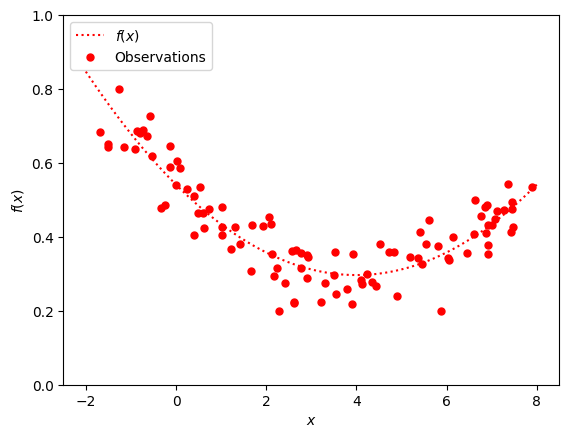

In [14]:
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as pl

def f(x):
    """The function to predict."""
    return 6*(x-4)**2+20

x = np.atleast_2d(np.linspace(-2, 8, 1000)).T

X = 10* np.random.random(100) - 2
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 15 + 15.0 * np.random.random(y.shape[0])
noise = np.random.normal(0, dy)
y += noise
scaler = MinMaxScaler((0.2, 0.8))
y = scaler.fit_transform(y.reshape(-1, 1)).ravel()

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()

# Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.calibration import calibration_curve

model = LinearRegression()
model.fit(X, y)

LinearRegression()

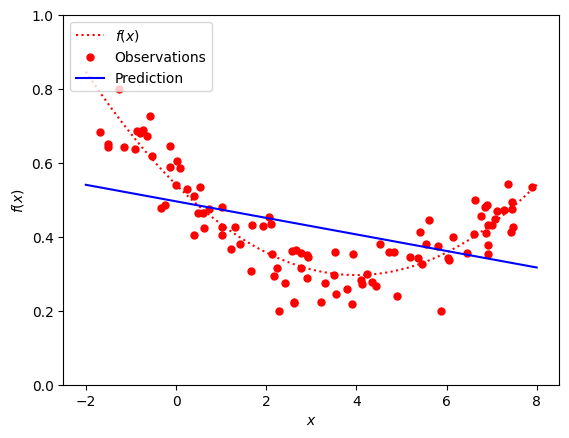

In [17]:
y_pred = model.predict(x)

plt.figure()

plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()

## 1. Reliability Diagram

Compare predictions with actual values in intervals.

* Divide predictions into quantiles.
* Calculate the mean of the predictions at each quantile.
* Compare with the actual mean observed at each quantile.

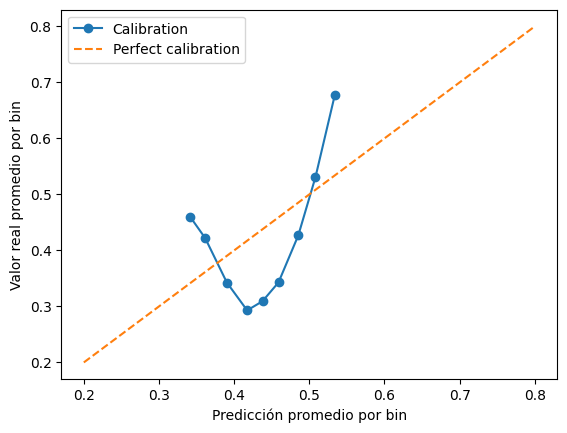

In [24]:
y_pred = model.predict(X)

percentiles = np.percentile(y_pred, np.linspace(0, 100, 10))
bins = np.digitize(y_pred, percentiles)
y_means = [y[bins == i].mean() for i in range(1, len(percentiles))]

# Reliability Diagram
plt.plot(percentiles[1:], y_means, 'o-', label="Calibration")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', label="Perfect calibration")
plt.xlabel("Predicción promedio por bin")
plt.ylabel("Valor real promedio por bin")
plt.legend()
plt.show()

# 2. Test de Normalidad en los Errores (Residuos)
* Verificar si los errores (y_real - y_pred) siguen una distribución normal con media 0.
* Un modelo bien calibrado debería producir errores centrados en 0 y con distribución normal.

p-value de Shapiro-Wilk: 0.15329733375963567


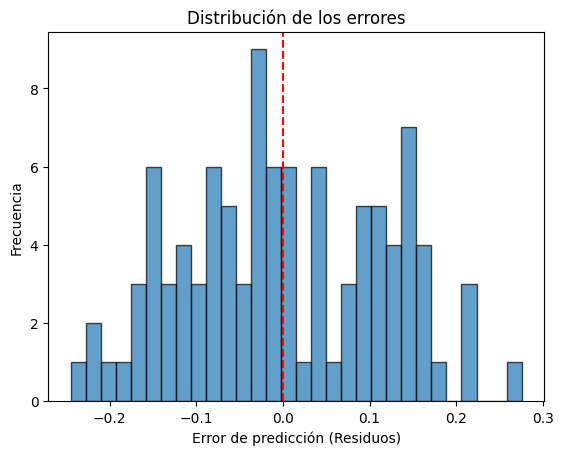

In [22]:
import scipy.stats as stats

residuals = y - y_pred

# Prueba de normalidad de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)
print(f"p-value de Shapiro-Wilk: {shapiro_test.pvalue}")

# Histograma de los residuos
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='dashed')
plt.xlabel("Error de predicción (Residuos)")
plt.ylabel("Frecuencia")
plt.title("Distribución de los errores")
plt.show()

# 3. Gráfico Q-Q de Residuos
* Comparar la distribución de los residuos con una normal teórica.

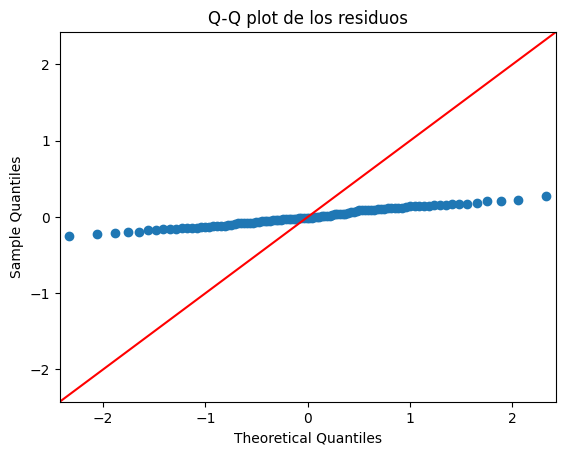

In [23]:
import statsmodels.api as sm

sm.qqplot(residuals, line='45')
plt.title("Q-Q plot de los residuos")
plt.show()

## 4. Calibration Based on Quantiles (Coverage Probability)
* Measure whether the actual values fall within the expected prediction intervals.
* If you have a model that predicts confidence intervals (e.g., quantile regression or conformal prediction), you can check whether the percentage of actual values within the interval matches the theoretical probability.

Porcentaje de valores reales dentro del intervalo 90%: 100.00%
Porcentaje de valores reales dentro del intervalo 80%: 100.00%


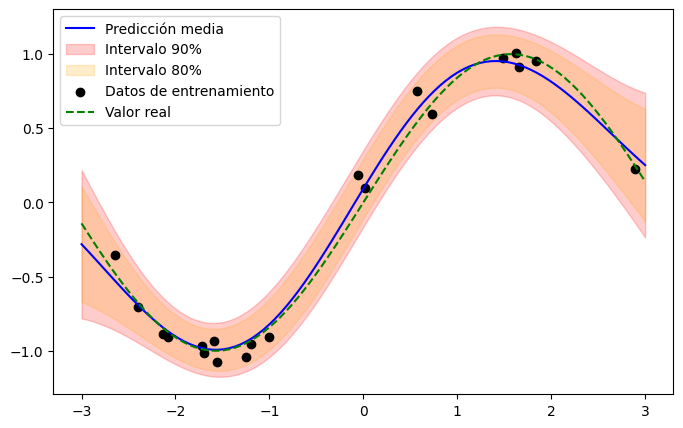

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt

# Simulación de datos
X_train = np.random.uniform(-3, 3, (20, 1))
y_train = np.sin(X_train).ravel() + np.random.normal(0, 0.1, X_train.shape[0])

X_test = np.linspace(-3, 3, 100).reshape(-1, 1)

# Entrenar un GP con kernel RBF
gp = GaussianProcessRegressor(kernel=RBF(length_scale=1.0), alpha=0.1)
gp.fit(X_train, y_train)

# Obtener predicciones y desviación estándar
y_pred, sigma = gp.predict(X_test, return_std=True)

# Construcción de intervalos de predicción (90% y 80%)
z_90, z_80 = 1.645, 1.28
lower_90, upper_90 = y_pred - z_90 * sigma, y_pred + z_90 * sigma
lower_80, upper_80 = y_pred - z_80 * sigma, y_pred + z_80 * sigma

# Evaluar la cobertura real
y_test_real = np.sin(X_test).ravel()  # Valores reales
coverage_90 = np.mean((y_test_real >= lower_90) & (y_test_real <= upper_90))
coverage_80 = np.mean((y_test_real >= lower_80) & (y_test_real <= upper_80))

print(f"Porcentaje de valores reales dentro del intervalo 90%: {coverage_90 * 100:.2f}%")
print(f"Porcentaje de valores reales dentro del intervalo 80%: {coverage_80 * 100:.2f}%")

# Gráfica de intervalos
plt.figure(figsize=(8, 5))
plt.plot(X_test, y_pred, label="Predicción media", color='blue')
plt.fill_between(X_test.ravel(), lower_90, upper_90, alpha=0.2, color='red', label="Intervalo 90%")
plt.fill_between(X_test.ravel(), lower_80, upper_80, alpha=0.2, color='orange', label="Intervalo 80%")
plt.scatter(X_train, y_train, color='black', label="Datos de entrenamiento")
plt.plot(X_test, y_test_real, '--', color='green', label="Valor real")
plt.legend()
plt.show()
